# PD4

Krzysztof Wolny  
WUM  
27.04.2021  

In [133]:
# wczytanie bibliotek
import dalex as dx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# Apartments

## Load data

In [134]:
# Wczytanie danych
apartments = dx.datasets.load_apartments()
apartments.head()

,m2_price,construction_year,surface,floor,no_rooms,district
1,5897,1953,25,3,1,Srodmiescie
2,1818,1992,143,9,5,Bielany
3,3643,1937,56,1,2,Praga
4,3517,1995,93,7,3,Ochota
5,3013,1992,144,6,5,Mokotow


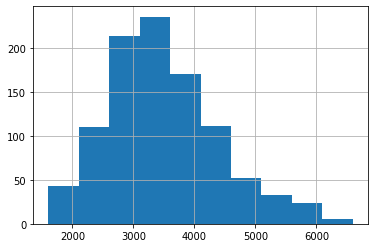

In [135]:
# Histogram zmiennej, którą będziemy chcieli przewidzieć
apartments["m2_price"].hist()
plt.show()

In [136]:
# One hot encoding kolumny 'district'
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

col_to_encode = ["district"]

for col in col_to_encode:

    le = LabelEncoder()
    label = le.fit_transform(apartments[col])

    onehot_encoder = OneHotEncoder(sparse=False)
    onehot_encoded = onehot_encoder.fit_transform(label.reshape(-1,1))

    dfonehot = pd.DataFrame(onehot_encoded)
    apartments = pd.concat([apartments.reset_index(drop=True), dfonehot], axis = 1)

#usuwamy "district" i 0 kolumnę, ponieważ nie zawierają żadnych nowych informacji
apartments = apartments.drop(["district", 0], axis=1) 
apartments.head()

,m2_price,construction_year,surface,floor,no_rooms,1,2,3,4,5,6,7,8,9
0,5897,1953,25,3,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1818,1992,143,9,5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3643,1937,56,1,2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,3517,1995,93,7,3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3013,1992,144,6,5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Train test split

In [137]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(apartments.drop(['m2_price'], axis=1), 
                                                    apartments['m2_price'], 
                                                    test_size=0.2, random_state=42)
X_train.head()

,construction_year,surface,floor,no_rooms,1,2,3,4,5,6,7,8,9
29,2002,88,6,3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
535,1937,98,4,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
695,1993,88,10,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
557,1970,44,8,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
836,2000,84,9,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## SVM

In [138]:
from sklearn.svm import SVR

svr = SVR()
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)

In [139]:
from sklearn.metrics import mean_squared_error

print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False)}")

RMSE: 973.9658734669498


## Scaling

In [140]:
# standaryzacja zmiennej surface 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

columns_to_scale = ['surface', 'construction_year']

X_train_sc = X_train.copy(deep=True)

scaler = StandardScaler()
for column in columns_to_scale: 
    X_train_sc[column] = scaler.fit_transform(X_train_sc[[column]]).reshape(-1,1)
    
X_train_sc.head()

,construction_year,surface,floor,no_rooms,1,2,3,4,5,6,7,8,9
29,1.419534,0.064233,6,3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
535,-1.113000,0.332567,4,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
695,1.068876,0.064233,10,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
557,0.172748,-1.116440,8,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
836,1.341610,-0.043101,9,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [141]:
from sklearn.svm import SVR

svr_sc = SVR()
svr_sc.fit(X_train_sc, y_train)
y_pred_sc = svr_sc.predict(X_test)

In [142]:
from sklearn.metrics import mean_squared_error

print(f"RMSE: {mean_squared_error(y_test, y_pred_sc, squared=False)}")

RMSE: 973.401781752498


Standaryzacja miała bardzo niewieli wpływ na wyniki

## Random Search

In [143]:
#zmienne, które można regulować w Random Search
svr.get_params().keys()

dict_keys(['C', 'cache_size', 'coef0', 'degree', 'epsilon', 'gamma', 'kernel', 'max_iter', 'shrinking', 'tol', 'verbose'])

In [144]:
# wykonanie Random Search
from sklearn.model_selection import RandomizedSearchCV

parameters = {'C' : list(np.arange(-10, 10, 0.1, dtype = 'float')), 
              'gamma' : ['scale', 'auto'], 
              'degree' : list(np.arange(2, 5, 1, dtype = 'int')), 
              'kernel' : ['linear', 'poly', 'rbf', 'sigmoid']}

random = RandomizedSearchCV(estimator=svr, 
                            param_distributions=parameters, 
                            cv = 3, 
                            n_jobs=-1, 
                            random_state=42, 
                            scoring = 'neg_root_mean_squared_error')

random_result = random.fit(X_train, y_train)

# Wyniki
print("Best RMSE: %f using %s" % (random_result.best_score_, random_result.best_params_))

Best RMSE: -587.725096 using {'kernel': 'linear', 'gamma': 'auto', 'degree': 2, 'C': 5.699999999999944}


Widać, że Random Search dał zdecydowaną poprawę wyniku. 

# World Happiness Report

Pobrałem bazę danych o szczęściu ludzi na świecie ze strony: https://www.kaggle.com/ajaypalsinghlo/world-happiness-report-2021. Moim targetem będzie 'Life Ladder', czyli indeks opisujący szczęście w danym miejscu. 

In [145]:
happiness = pd.read_csv('archive/world-happiness-report.csv')
happiness.head()

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.370,0.451,50.80,0.718,0.168,0.882,0.518,0.258
1,Afghanistan,2009,4.402,7.540,0.552,51.20,0.679,0.190,0.850,0.584,0.237
2,Afghanistan,2010,4.758,7.647,0.539,51.60,0.600,0.121,0.707,0.618,0.275
3,Afghanistan,2011,3.832,7.620,0.521,51.92,0.496,0.162,0.731,0.611,0.267
4,Afghanistan,2012,3.783,7.705,0.521,52.24,0.531,0.236,0.776,0.710,0.268


In [146]:
happiness.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1949 entries, 0 to 1948
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country name                      1949 non-null   object 
 1   year                              1949 non-null   int64  
 2   Life Ladder                       1949 non-null   float64
 3   Log GDP per capita                1913 non-null   float64
 4   Social support                    1936 non-null   float64
 5   Healthy life expectancy at birth  1894 non-null   float64
 6   Freedom to make life choices      1917 non-null   float64
 7   Generosity                        1860 non-null   float64
 8   Perceptions of corruption         1839 non-null   float64
 9   Positive affect                   1927 non-null   float64
 10  Negative affect                   1933 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 167.6+ KB


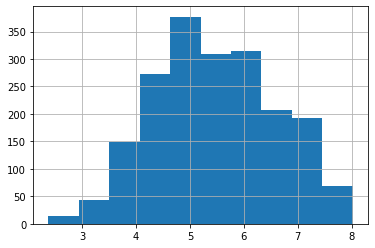

In [147]:
happiness["Life Ladder"].hist()
plt.show()

In [148]:
# Usuwam dane z NaN. Przez to tracę ok 150 obserwacji, co jeszcze jest akceptowalne. 
happiness = happiness.dropna()
happiness.shape[0]

1708

In [149]:
# One hot encoding kolumny 'Country name'
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

col_to_encode = ["Country name"]

for col in col_to_encode:

    le = LabelEncoder()
    label = le.fit_transform(happiness[col])

    onehot_encoder = OneHotEncoder(sparse=False)
    onehot_encoded = onehot_encoder.fit_transform(label.reshape(-1,1))

    dfonehot = pd.DataFrame(onehot_encoded)
    happiness = pd.concat([happiness.reset_index(drop=True), dfonehot], axis = 1)

happiness = happiness.drop(["Country name", 0], axis=1)
happiness.head()

,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,...,145,146,147,148,149,150,151,152,153,154
0,2008,3.724,7.370,0.451,50.80,0.718,0.168,0.882,0.518,0.258,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2009,4.402,7.540,0.552,51.20,0.679,0.190,0.850,0.584,0.237,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2010,4.758,7.647,0.539,51.60,0.600,0.121,0.707,0.618,0.275,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2011,3.832,7.620,0.521,51.92,0.496,0.162,0.731,0.611,0.267,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2012,3.783,7.705,0.521,52.24,0.531,0.236,0.776,0.710,0.268,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Train test split

In [150]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(happiness.drop(['Life Ladder'], axis=1), 
                                                    happiness['Life Ladder'], 
                                                    test_size=0.2, random_state=42)
X_train.head()

,year,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,1,...,145,146,147,148,149,150,151,152,153,154
590,2015,10.259,0.835,71.8,0.532,-0.272,0.824,0.740,0.277,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1551,2019,9.283,0.610,67.2,0.659,-0.209,0.889,0.539,0.433,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
420,2018,10.935,0.958,72.4,0.935,0.018,0.151,0.821,0.206,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
425,2011,7.880,0.633,54.7,0.746,-0.057,0.519,0.579,0.181,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
857,2010,9.878,0.721,65.2,0.678,0.073,0.949,0.525,0.341,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## SVM

In [151]:
from sklearn.svm import SVR

svr = SVR()
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)

In [152]:
from sklearn.metrics import mean_squared_error

print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False)}")

RMSE: 1.1055864781558975


## Scaling

In [153]:
happiness.columns

Index([                            'year',                      'Life Ladder',
                     'Log GDP per capita',                   'Social support',
       'Healthy life expectancy at birth',     'Freedom to make life choices',
                             'Generosity',        'Perceptions of corruption',
                        'Positive affect',                  'Negative affect',
       ...
                                      145,                                146,
                                      147,                                148,
                                      149,                                150,
                                      151,                                152,
                                      153,                                154],
      dtype='object', length=164)

In [154]:
# standaryzacja zmiennych
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

columns_to_scale = ['Log GDP per capita',                 'Social support',
       'Healthy life expectancy at birth',     'Freedom to make life choices',
                             'Generosity',        'Perceptions of corruption',
                        'Positive affect',                  'Negative affect']

X_train_sc = X_train.copy(deep=True)

scaler = StandardScaler()
for column in columns_to_scale: 
    X_train_sc[column] = scaler.fit_transform(X_train_sc[[column]]).reshape(-1,1)
    
X_train_sc.head()

,year,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,1,...,145,146,147,148,149,150,151,152,153,154
590,2015,0.794793,0.204389,1.102626,-1.460309,-1.675549,0.387285,0.286607,0.090641,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1551,2019,-0.046265,-1.602152,0.505153,-0.563695,-1.285628,0.742233,-1.574747,1.974868,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
420,2018,1.377329,1.191964,1.180558,1.384852,0.119326,-3.287792,1.036705,-0.766924,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
425,2011,-1.255287,-1.417483,-1.118415,0.050521,-0.344866,-1.278240,-1.204329,-1.068883,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
857,2010,0.466470,-0.710925,0.245383,-0.429556,0.459734,1.069877,-1.704394,0.863657,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [155]:
from sklearn.svm import SVR

svr_sc = SVR()
svr_sc.fit(X_train_sc, y_train)
y_pred_sc = svr_sc.predict(X_test)

In [156]:
from sklearn.metrics import mean_squared_error

print(f"RMSE: {mean_squared_error(y_test, y_pred_sc, squared=False)}")

RMSE: 1.1213221636810928


Znowu nie wyszedł znaczący wpływ standaryzacji na wyniki

## Random search

In [157]:
from sklearn.model_selection import RandomizedSearchCV

parameters = {'C' : list(np.arange(-10, 10, 0.1, dtype = 'float')), 
              'gamma' : ['scale', 'auto'], 
              'degree': list(np.arange(2, 5, 1, dtype = 'int')), 
              'kernel' : ['linear', 'poly', 'rbf', 'sigmoid']}

random = RandomizedSearchCV(estimator=svr, 
                            param_distributions=parameters, 
                            cv = 3, 
                            n_jobs=-1, 
                            random_state=42, 
                            scoring = 'neg_root_mean_squared_error')

random_result = random.fit(X_train, y_train)

# Summarize results
print("Best RMSE: %f using %s" % (random_result.best_score_, random_result.best_params_))

Best RMSE: -1.038865 using {'kernel': 'rbf', 'gamma': 'scale', 'degree': 3, 'C': 8.399999999999935}


Random Search natomiast znowu polepsza SVR. 